In [1]:
import numpy as np
import pandas as pd

from scipy.special import gamma, digamma, polygamma
from scipy.stats import poisson

from sklearn.linear_model import PoissonRegressor

import matplotlib.pyplot as plt

\begin{align*}
    \ell(U, V; X) &= \sum_i \ln\left(\frac{e^{U_i\theta(X,V)^\top X_i}}{U_i!}\exp\left(-e^{\theta(X,V)^\top X_i }\right) \right) \\
    &= \sum_i U_i\theta(X,V)^\top X_i - \ln(U_i!) - e^{\theta(X,V)^\top X_i}
\end{align*}
So
\begin{gather*}
%    \nabla_{U_i} \ell(U, V; X) = \theta(X,V)^\top X_i - \Psi(U_i + 1) \\
    \nabla_{U} \ell(U, V; X) = X\theta(X,V) - \Psi(U + 1) \\
    \nabla_{U}^2 \ell(U, V; X) = -diag \left(\Psi^{(2)}(U + 1)\right)
\end{gather*}
By Taylor's Theorem
\begin{align*}
    \ell(Y^*, Y; X) &\approx \ell(Y, Y; X) + (Y^* - Y)^\top \nabla_U \ell(Y, Y; X) + \frac{1}{2}(Y^* - Y)^\top \nabla_U^2 \ell(Y, Y; X) (Y^* - Y) \\
    &= \ell(Y, Y; X) + (Y^* - Y)^\top \left( X\theta(X,Y) - \Psi(Y + 1) \right) - \frac{1}{2}(Y^* - Y)^\top diag \left(\Psi^{(2)}(Y + 1)\right) (Y^* - Y) \\
\end{align*}
So hopefully in expectation its close...

In [2]:
def loglik(theta, X, y):
    return np.mean(poisson.logpmf(y, mu=X.dot(theta)))

In [3]:
def grad_loglik(theta, X, y):
    n = y.shape[0]
    return (X.dot(theta) - digamma(y+1)) / n

In [4]:
def hess_loglik(y):
    n = y.shape[0]
    return -np.diag(polygamma(3,y+1)) / n

In [5]:
def third_derivative_loglik(y):
    n = y.shape[0]
    return -polygamma(4,y+1) / n

In [6]:
def est_loglik(theta, X, y, y_star, third_order=False):
    delta = y_star - y
    return (
#         (
            loglik(theta, X, y) + 
            delta.dot(grad_loglik(theta, X, y)) + 
            delta.dot(hess_loglik(y).dot(delta))/2. +
            third_order*(delta**3).dot(third_derivative_loglik(y)) / 6.
#         ),
#         (delta**3).dot(third_derivative_loglik(y))
    )

In [7]:
loglik(
    np.array([2,1,3]),
    np.array([[5,1],[1,0],[7,2]]).T,
    np.array([3,0])
), grad_loglik(
    np.array([2,1,3]),
    np.array([[5,1],[1,0],[7,2]]).T,
    np.array([3,0])
), hess_loglik(
    np.array([3,0])
), third_derivative_loglik(
    np.array([3,0])
), est_loglik(
    np.array([2,1,3]),
    np.array([[5,1],[1,0],[7,2]]).T,
    np.array([3,0]),
    np.array([2,1])
)

(-15.697275880414438,
 array([15.37194117,  4.28860783]),
 array([[-0.02243266, -0.        ],
        [-0.        , -3.2469697 ]]),
 array([ 0.01875035, 12.44313306]),
 -28.41531039636267)

## Start with IID poisson entries

In [8]:
lam = 3.
n = 50
p = 10
y = poisson.rvs(mu=lam, size=n)
y_star = poisson.rvs(mu=lam, size=n)

In [9]:
y

array([3, 4, 5, 5, 2, 3, 1, 5, 3, 2, 1, 1, 1, 6, 3, 1, 4, 2, 3, 2, 4, 4,
       3, 4, 3, 3, 4, 2, 3, 3, 7, 1, 4, 2, 3, 1, 5, 1, 1, 4, 0, 2, 4, 6,
       5, 3, 4, 2, 4, 4])

In [10]:
y_star

array([3, 1, 5, 3, 2, 3, 7, 2, 3, 3, 3, 1, 3, 1, 1, 6, 2, 3, 2, 3, 7, 2,
       0, 6, 8, 3, 1, 3, 3, 5, 2, 5, 3, 5, 7, 3, 5, 1, 4, 3, 4, 3, 3, 4,
       2, 1, 1, 2, 2, 3])

In [11]:
niters = 500

Ys = np.zeros((n, niters))
Y_stars = np.zeros((n, niters))
    
X = np.hstack((np.ones((n,1)),np.fabs(np.random.randn(n,p))))
theta_0 = np.random.uniform(0,3,(p+1))
lam = X.dot(theta_0)

for i in np.arange(niters):
    Ys[:,i] = poisson.rvs(mu=lam, size=n)
    Y_stars[:,i] = poisson.rvs(mu=lam, size=n)

In [12]:
test_errs = []
est_errs = []
third_est_errs = []
naive_errs = []
thetas = []
for i in np.arange(niters):
    y = Ys[:,i]
    y_star = Y_stars[:,i]
    
    pm = PoissonRegressor(alpha=0, fit_intercept=False)
    pm.fit(X, y)
    theta = pm.coef_
    thetas.append(theta)
#     if i == 0:
#         print(loglik(theta, X, y))
    naive_errs.append(loglik(theta, X, y))
    test_errs.append(loglik(theta, X, y_star))
    est_errs.append(est_loglik(theta, X, y, y_star, third_order=False))
    third_est_errs.append(est_loglik(theta, X, y, y_star, third_order=True))

In [13]:
np.mean(test_errs), np.mean(naive_errs), np.mean(est_errs), np.mean(third_est_errs),

(-12.282368631358098,
 -12.24922702412293,
 -11.524830822897387,
 -11.32883783987426)

In [14]:
np.std(test_errs), np.std(naive_errs), np.std(est_errs), np.std(third_est_errs)

(0.844876767478407, 0.666447185413693, 0.6779526096687571, 1.379880217904812)

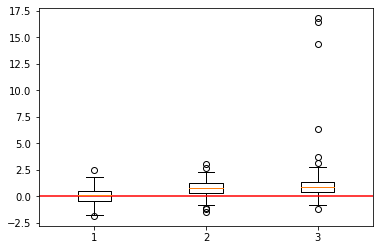

In [15]:
fig = plt.boxplot([naive_errs-np.mean(test_errs), est_errs-np.mean(test_errs), third_est_errs-np.mean(test_errs)])
plt.axhline(y=0., color='r', linestyle='-')

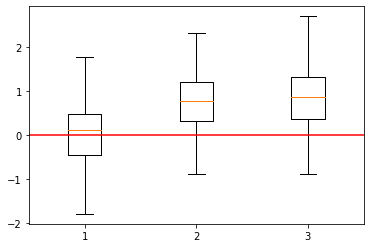

In [16]:
fig = plt.boxplot([naive_errs-np.mean(test_errs), est_errs-np.mean(test_errs), third_est_errs-np.mean(test_errs)], showfliers=False)
plt.axhline(y=0., color='r', linestyle='-')

## Now what if Poisson's correlated
Simple case, shared core Poisson, then added Poisson noise

In [17]:
niters = 500
core_mu = 3

Ys = np.zeros((n, niters))
Y_stars = np.zeros((n, niters))
cores = np.zeros(niters)
star_cores = np.zeros(niters)
    
X = np.hstack((np.ones((n,1)),np.fabs(np.random.randn(n,p))))
theta_0 = np.random.uniform(0,3,(p+1))
lam = X.dot(theta_0)


for i in np.arange(niters):
    cores[i] = poisson.rvs(mu=core_mu, size=1)
    star_cores[i] = poisson.rvs(mu=core_mu, size=1)
    Ys[:,i] = cores[i] + poisson.rvs(mu=lam, size=n)
    Y_stars[:,i] = star_cores[i] + poisson.rvs(mu=lam, size=n)

In [18]:
test_errs = []
est_errs = []
third_est_errs = []
naive_errs = []
thetas = []
for i in np.arange(niters):
    y = Ys[:,i]
    y_star = Y_stars[:,i]
    
    pm = PoissonRegressor(alpha=0, fit_intercept=False)
    pm.fit(X, y)
    theta = pm.coef_
    thetas.append(theta)
#     if i == 0:
#         print(loglik(theta, X, y))
    naive_errs.append(loglik(theta, X, y))
    test_errs.append(loglik(theta, X, y_star))
    est_errs.append(est_loglik(theta, X, y, y_star, third_order=False))
    third_est_errs.append(est_loglik(theta, X, y, y_star, third_order=True))

In [19]:
np.mean(test_errs), np.mean(naive_errs), np.mean(est_errs), np.mean(third_est_errs),

(-15.693605187651793,
 -15.353725710648614,
 -14.779284302747216,
 -14.729799373256347)

In [20]:
np.std(test_errs), np.std(naive_errs), np.std(est_errs), np.std(third_est_errs)

(3.1965864429295894, 2.5964156500031716, 2.6112981093754946, 2.684786329219623)

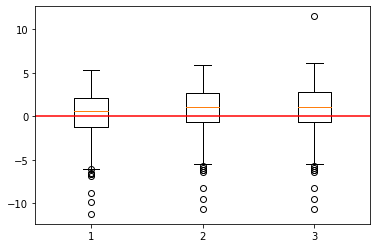

In [21]:
fig = plt.boxplot([naive_errs-np.mean(test_errs), est_errs-np.mean(test_errs), third_est_errs-np.mean(test_errs)])
plt.axhline(y=0., color='r', linestyle='-')

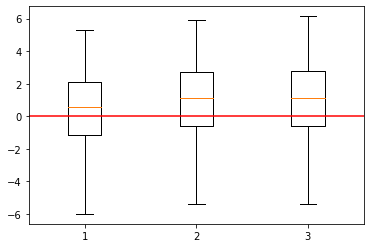

In [22]:
fig = plt.boxplot([naive_errs-np.mean(test_errs), est_errs-np.mean(test_errs), third_est_errs-np.mean(test_errs)], showfliers=False)
plt.axhline(y=0., color='r', linestyle='-')

## Additive correlation structure

In [23]:
niters = 500
# core_mu = 3

Ys = np.zeros((n, niters))
Y_stars = np.zeros((n, niters))
cores = np.zeros(niters)
star_cores = np.zeros(niters)
    
X = np.hstack((np.ones((n,1)),np.fabs(np.random.randn(n,p))))
theta_0 = np.random.uniform(0,3,(p+1))
lam = X.dot(theta_0)

m = int(n/2)

for i in np.arange(niters):
#     cores[i] = poisson.rvs(mu=core_mu, size=1)
#     star_cores[i] = poisson.rvs(mu=core_mu, size=1)
    Ys[:m,i] = poisson.rvs(mu=lam[:m], size=m)
    Ys[m:,i] = Ys[:m,i] + poisson.rvs(mu=lam[m:], size=m)
    Y_stars[:m,i] = poisson.rvs(mu=lam[:m], size=m)
    Y_stars[m:,i] = Y_stars[:m,i] + poisson.rvs(mu=lam[m:], size=m)

In [24]:
test_errs = []
est_errs = []
third_est_errs = []
naive_errs = []
thetas = []
for i in np.arange(niters):
    y = Ys[:,i]
    y_star = Y_stars[:,i]
    
    pm = PoissonRegressor(alpha=0, fit_intercept=False)
    pm.fit(X, y)
    theta = pm.coef_
    thetas.append(theta)
#     if i == 0:
#         print(loglik(theta, X, y))
    naive_errs.append(loglik(theta, X, y))
    test_errs.append(loglik(theta, X, y_star))
    est_errs.append(est_loglik(theta, X, y, y_star, third_order=False))
    third_est_errs.append(est_loglik(theta, X, y, y_star, third_order=True))

In [25]:
np.mean(test_errs), np.mean(naive_errs), np.mean(est_errs), np.mean(third_est_errs),

(-24.533072389240843,
 -24.562703065926392,
 -23.842699875109325,
 -23.792800280396616)

In [26]:
np.std(test_errs), np.std(naive_errs), np.std(est_errs), np.std(third_est_errs)

(1.5450635181965617, 1.314756215064668, 1.3243437317884141, 1.3690939209151454)

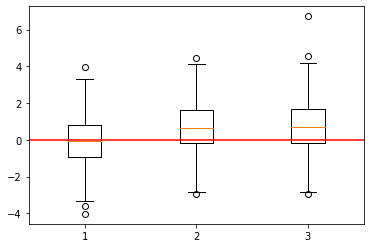

In [27]:
fig = plt.boxplot([naive_errs-np.mean(test_errs), est_errs-np.mean(test_errs), third_est_errs-np.mean(test_errs)])
plt.axhline(y=0., color='r', linestyle='-')

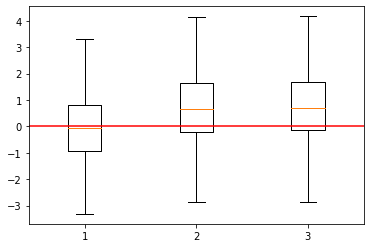

In [28]:
fig = plt.boxplot([naive_errs-np.mean(test_errs), est_errs-np.mean(test_errs), third_est_errs-np.mean(test_errs)], showfliers=False)
plt.axhline(y=0., color='r', linestyle='-')